## 使用正弦函数和一些可加性噪声来生成序列数据

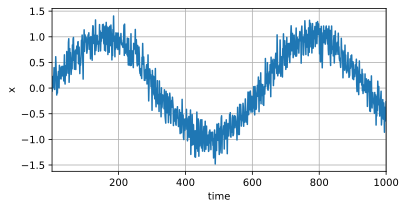

In [8]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=d2l.float32)
# 正弦函数加上正太分布的噪声
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [9]:
# 设置预测依赖的个数
tau = 4
# 前tau个元素无法依赖tau个元素进行预测
# 共T - tau个元素构建T - tau行，tau列的矩阵，每行为对应列的依赖元素
features = torch.zeros((T - tau, tau))
# 通过依赖个数进行循环遍历
for i in range(tau):
    # 一次将每个行的一列依赖元素存入特征列表中
    features[:, i] = x[i: T - tau + i]
# 标签为tau个元素之后的所有元素，转换为与特征对应的维度
labels = x[tau:].reshape((-1, 1))

# 训练批大小和训练样本个数
batch_size, n_train = 16, 600
# 只有前`n_train`个样本用于训练
# 数据迭代器
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, 
                            is_train=True)

In [10]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失
loss = nn.MSELoss()

In [11]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.068000
epoch 2, loss: 0.056908
epoch 3, loss: 0.052890
epoch 4, loss: 0.052981
epoch 5, loss: 0.049734


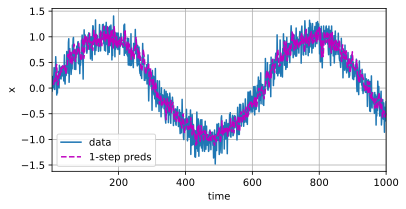

In [12]:
onestep_preds = net(features)
# detach()截断反向传播的梯度流
d2l.plot([time, time[tau:]], 
         [x.detach().numpy(), onestep_preds.detach().numpy()], 
         'time',
         'x', 
         legend=['data', '1-step preds'], 
         xlim=[1, 1000], 
         figsize=(6, 3))

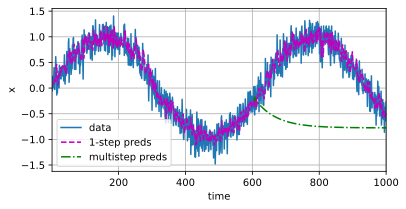

In [13]:
# 通过四个样本预测后续所有样本
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(), multistep_preds[n_train + tau:].detach().numpy()], 
         'time',
         'x', 
         legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], 
         figsize=(6, 3))

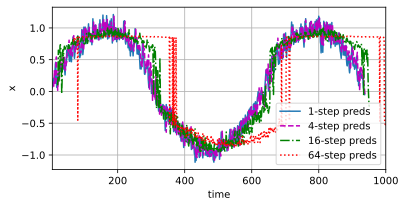

In [14]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列 `i` (`i` < `tau`) 是来自 `x` 的观测
# 其时间步从 `i + 1` 到 `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列 `i` (`i` >= `tau`) 是 (`i - tau + 1`)步的预测
# 其时间步从 `i + 1` 到 `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 
         'time', 
         'x',
         legend=[f'{i}-step preds' for i in steps], 
         xlim=[5, 1000],
         figsize=(6, 3))